In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error

In [8]:
train_df = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',index_col='id')
train_df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [9]:
test_df = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',index_col='id')
test_df.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [10]:
#change the date column into usabel data
train_df.date = pd.to_datetime(train_df.date)
test_df.date= pd.to_datetime(test_df.date)

train_df['year'] = train_df.date.dt.year
test_df['year'] = test_df.date.dt.year

train_df['month'] = train_df.date.dt.month
test_df['month'] = test_df.date.dt.month

train_df['dayofmonth'] = train_df.date.dt.day
test_df['dayofmonth'] = test_df.date.dt.day

train_df['dayofweek'] = train_df.date.dt.dayofweek
test_df['dayofweek'] = test_df.date.dt.dayofweek

train_df['dayname'] = train_df.date.dt.strftime('%A')
test_df['dayname'] = test_df.date.dt.strftime('%A')

In [11]:
train_df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

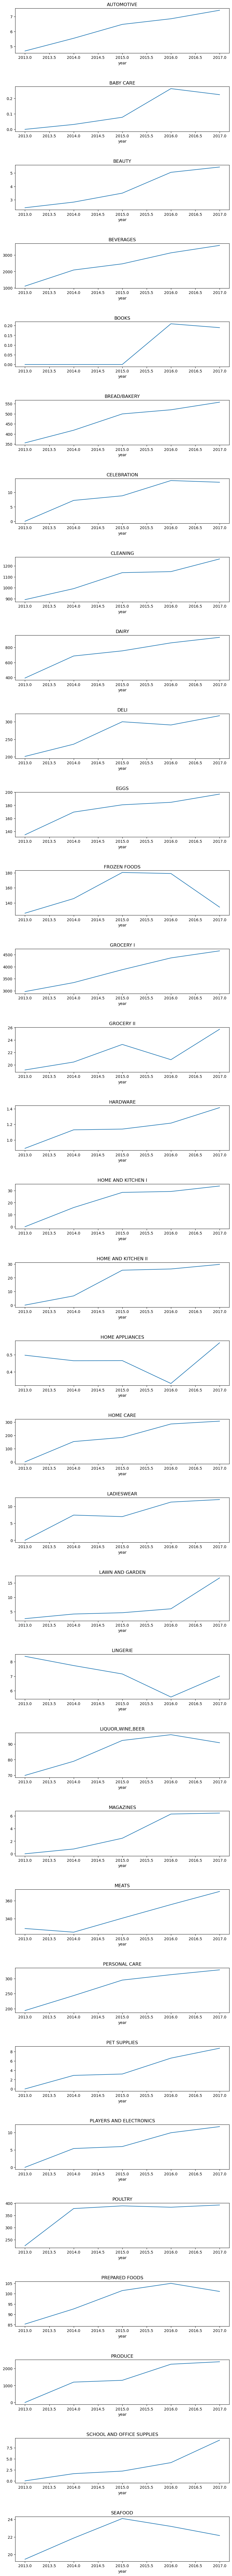

In [12]:
fig= plt.figure(figsize=(10,120))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(train_df.family.unique()):
    ax = fig.add_subplot(33,1,i+1)
    train_df.query('family==@product').groupby(['year']).sales.mean().plot()
    plt.title(product);

In [13]:
#frozen foods, baby care, liquor, beer, and wine all decreased during the period after 2016

#now on to missing values
print(train_df.isna().sum())
print(test_df.isna().sum())

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
dayofmonth     0
dayofweek      0
dayname        0
dtype: int64
date           0
store_nbr      0
family         0
onpromotion    0
year           0
month          0
dayofmonth     0
dayofweek      0
dayname        0
dtype: int64


Text(0.5, 1.0, 'Sales')

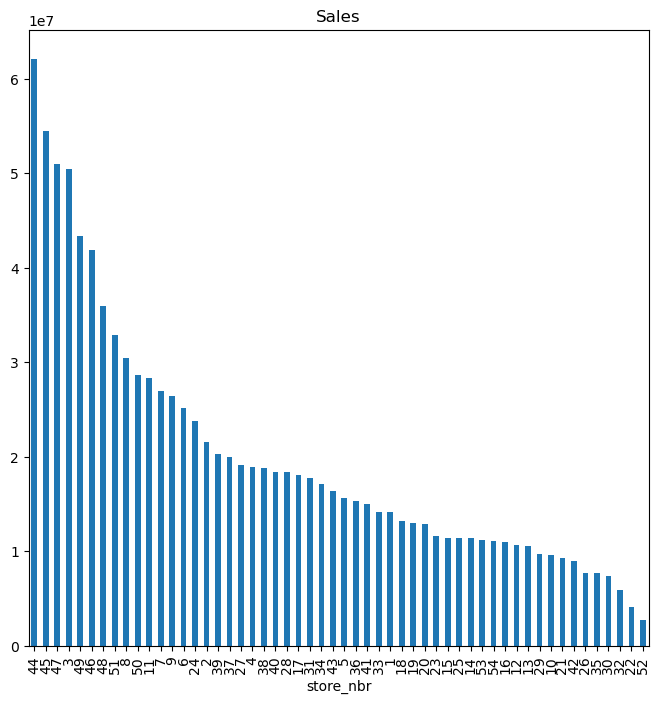

In [14]:
#sales store ranking
plt.figure(figsize=(8,8))
train_df.groupby('store_nbr').sales.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Sales')

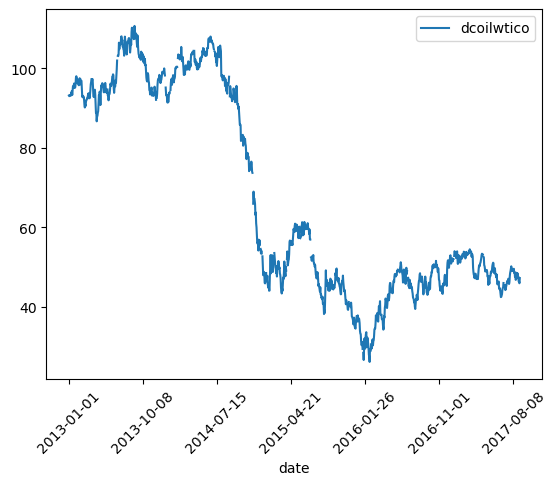

In [15]:
#oil is important for ecuador so here is a chart for oil
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv',index_col='date')
oil.plot();
plt.xticks(rotation=45);

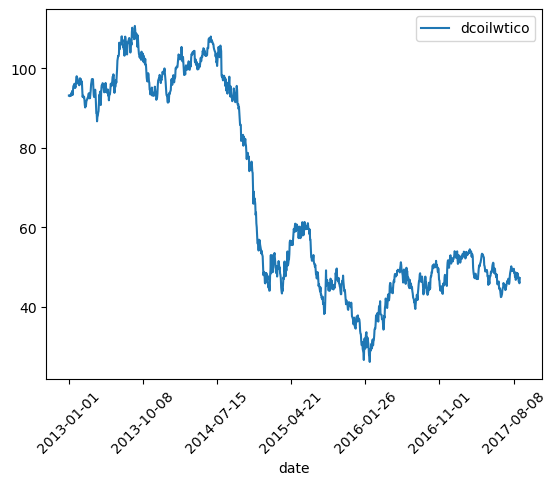

In [16]:
#there are missing values
oil = oil.interpolate(method='linear')
#the first row is still missing the value
oil.iloc[0] = oil.iloc[1]
oil.plot();
plt.xticks(rotation=45);

In [18]:
import datetime

#some days are skipped, filling up the gap

start_date = train_df.date.min() 
# from beggining of the train date and the end of test date
number_of_days = 1704 #1703
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')

In [20]:
oil.set_index('date').dcoilwtico.plot()
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()

KeyError: "None of ['date'] are in the columns"

In [22]:
oil['date_str'] = oil.index.astype(str)

In [23]:
# add oil price to the train date
train_df['date_str'] = train_df.date.astype(str)

train_df = pd.merge(train_df,oil,how='left',on='date_str')
train_df.drop(columns='date_str',axis=1,inplace=True)

In [24]:
test_df['date_str'] = test_df.date.astype(str)
test_df = pd.merge(test_df,oil,how='left', on='date_str')

test_df.drop(columns='date_str',axis=1,inplace=True)

In [25]:
#analyze stores now
stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv',index_col='store_nbr')
train_df = pd.merge(train_df,stores,how='left',on='store_nbr')
test_df = pd.merge(test_df,stores,how='left',on='store_nbr')

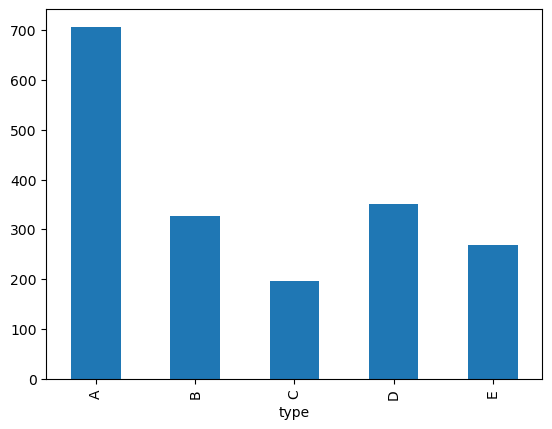

In [26]:
train_df.groupby(['type']).sales.mean().plot(kind='bar');

In [27]:
train_df.groupby(['cluster','store_nbr','city','type']).nunique()

date  family  sales  onpromotion  year  \
cluster store_nbr city          type                                           
1       24        Guayaquil     D     1684      33  15182          160     5   
        25        Salinas       D     1684      33  12023          149     5   
        27        Daule         D     1684      33  15260          159     5   
2       37        Cuenca        D     1684      33  15065          173     5   
        42        Cuenca        D     1684      33   7676          157     5   
3       16        Santo Domingo C     1684      33   7431          116     5   
        30        Guayaquil     C     1684      33   6665          108     5   
        32        Guayaquil     C     1684      33   6402           97     5   
        33        Quevedo       C     1684      33   8091          130     5   
        35        Playas        C     1684      33   6851          107     5   
        40        Machala       C     1684      33   8998          127     5   
        54        El Carmen     C     1684      33   7546          180     5   
4       5         Santo Domingo D     1684      33  14753          165     5   
        38        Loja          D     1684      33  15025          169     5   
        41        Machala       D     1684      33  14040          165     5   
5       44        Quito         A     1684      33  18368          199     5   
6       9         Quito         B     1684      33  13939          155     5   
        11        Cayambe       B     1684      33  12111          152     5   
        20        Quito         B     1684      33   8613          154     5   
        21        Santo Domingo B     1684      33   6698          147     5   
        34        Guayaquil     B     1684      33  11151          139     5   
        39        Cuenca        B     1684      33  13105          170     5   
7       14        Riobamba      C     1684      33   7562          115     5   
        22        Puyo          C     1684      33   3970          114     5   
8       3         Quito         D     1684      33  17801          193     5   
        7         Quito         D     1684      33  15462          180     5   
        8         Quito         D     1684      33  16181          179     5   
9       4         Quito         D     1684      33  15031          168     5   
        23        Ambato        D     1684      33  13308          159     5   
10      26        Guayaquil     D     1684      33  10077          126     5   
        28        Guayaquil     E     1684      33  12604          148     5   
        29        Guayaquil     E     1684      33   7463          155     5   
        31        Babahoyo      B     1684      33  11503          140     5   
        36        Libertad      E     1684      33  11242          153     5   
        43        Esmeraldas    E     1684      33   9372          135     5   
11      45        Quito         A     1684      33  18217          199     5   
        49        Quito         A     1684      33  17364          194     5   
        52        Manta         A     1684      33   1681          103     5   
12      17        Quito         C     1684      33   8313          137     5   
13      1         Quito         D     1684      33  13668          155     5   
        2         Quito         D     1684      33  14579          174     5   
        6         Quito         D     1684      33  15947          177     5   
        53        Manta         D     1684      33  10030          239     5   
14      46        Quito         A     1684      33  17221          189     5   
        47        Quito         A     1684      33  18004          200     5   
        48        Quito         A     1684      33  16930          191     5   
        50        Ambato        A     1684      33  16358          183     5   
15      10        Quito         C     1684      33   7330          108     5   
        12        Latacunga     C     

In [28]:
holiday_df = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
holiday_df.query('transferred==True')

# transferred day is not celebrated
holiday_df = holiday_df.query('transferred ==False')
holiday_df.description = holiday_df.description.str.replace('Traslado ','')

In [29]:
#national
national = holiday_df.query('locale=="National"')

day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()

train_df['date_str'] = train_df.date.astype(str)
test_df['date_str'] = test_df.date.astype(str)

train_df['national_holiday'] = [1 if a in day_off else 0 for a in train_df.date_str]
test_df['national_holiday'] = [1 if a in day_off else 0 for a in test_df.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()

train_df['national_event'] =[1 if a in event else 0 for a in train_df.date_str]
test_df['national_event'] =[1 if a in event else 0 for a in test_df.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_df['national_workday'] = [1 if a in work_day else 0 for a in train_df.date_str]
test_df['national_workday'] = [1 if a in work_day else 0 for a in test_df.date_str]


In [30]:
#weekend
train_df['weekend'] = [1 if a>=5 else 0 for a in train_df.dayofweek]
test_df['weekend'] = [1 if a>=5 else 0 for a in test_df.dayofweek]

In [31]:
train_df.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month',
       'dayofmonth', 'dayofweek', 'dayname', 'date_x', 'date_y', 'dcoilwtico',
       'city', 'state', 'type', 'cluster', 'date_str', 'national_holiday',
       'national_event', 'national_workday', 'weekend'],
      dtype='object')